In [51]:
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
import requests
from io import StringIO
from rdkit.Chem import AllChem

In [95]:
from collections import namedtuple

In [164]:
Missing = namedtuple('Missing', ["ifmissing", "missing_ress", "num_per_chain"])
Residue = namedtuple('Residue', ["chain", "name", "num"])
Ligand = namedtuple('Ligand', ["name", "numatom", "chain", "syn"])

def get_rec(pdb):
    with open(pdb, 'r') as f:
        lines = f.readlines()
    title = None
    res = None
    chain = None
    missing_res = Missing(ifmissing=False, missing_ress=[], num_per_chain=[])
    ligands = []

    for line in lines:
        if line.startswith('TITLE'):
            title = ' '.join(line.split()[1:])
        if line.startswith('REMARK   2 RESOLUTION'):
            res = line.split()[3]
        if line.startswith('COMPND   3 CHAIN'):
            chain = [x.rstrip(';|,') for x in line.split()[3:]]
        if line.startswith('REMARK 465') and 'MISSING RESIDUES' in line:
            missing_res = missing_res._replace(ifmissing=True)
        if line.startswith('REMARK 465') and missing_res.ifmissing:
            if any(keyword in line for keyword in ['MISSING RESIDUES', 'RES C SSSEQI', '---', 'RESIDUES', 'EXPERIMENT', 'IDENTIFIER']):
                continue
            miss_line = line.split()
            if len(miss_line) >= 5 and miss_line[0] == 'REMARK' and miss_line[1] == '465':
                missing_residue = Residue(chain=miss_line[3], name=miss_line[2], num=miss_line[4])
                missing_res.missing_ress.append(missing_residue)
        if line.startswith('HET   '):
            parts = line.split()
            ligands.append(Ligand(name=parts[1], numatom=parts[4], chain=parts[2], syn=[]))
        if line.startswith('HETNAM') or line.startswith('HETSYN'):
            parts = line.split()
            for ligand in ligands:
                if ligand.name in parts:
                    for item in parts[1:]:
                        ligand.syn.append(item)
                    ligand.syn.sort()
    for chain_ in chain:
        missing_in_chain_ = []
        for missing in missing_res.missing_ress:
            if missing.chain == chain_:
                missing_in_chain_.append((missing.name, missing.num))
        missing_res.num_per_chain.append((chain_, len(missing_in_chain_)))
    return title, res, chain, missing_res, ligands

In [165]:
get_rec('./6HD4.pdb')

('ABL1 IN COMPLEX WITH COMPOUND 7 AND IMATINIB (STI-571)',
 '2.03',
 ['A', 'B'],
 Missing(ifmissing=True, missing_ress=[Residue(chain='A', name='THR', num='296'), Residue(chain='A', name='GLY', num='530'), Residue(chain='A', name='LYS', num='531'), Residue(chain='A', name='ARG', num='532'), Residue(chain='A', name='GLY', num='533'), Residue(chain='A', name='THR', num='534'), Residue(chain='B', name='GLY', num='242'), Residue(chain='B', name='ALA', num='243'), Residue(chain='B', name='GLU', num='294'), Residue(chain='B', name='ASP', num='295'), Residue(chain='B', name='THR', num='296'), Residue(chain='B', name='GLY', num='530'), Residue(chain='B', name='LYS', num='531'), Residue(chain='B', name='ARG', num='532'), Residue(chain='B', name='GLY', num='533'), Residue(chain='B', name='THR', num='534')], num_per_chain=[('A', 6), ('B', 10)]),
 [Ligand(name='GOL', numatom='6', chain='A', syn=['GLYCERIN;', 'GLYCEROL', 'GOL', 'GOL', 'PROPANE-1,2,3-TRIOL']),
  Ligand(name='CL', numatom='1', chain=

In [47]:
def get_ligands(pdb, ligand, chain=None):
    with open(pdb) as f:
        lines = f.readlines()
        ligand_lines = []
        for line in lines:
            if line.startswith(('HETATM', 'ATOM')) and ligand in line:
                if chain:
                    # Chain ID is at position 21 (0-indexed) in PDB format
                    line_chain = line[21] if len(line) > 21 else ' '
                    if line_chain == chain:
                        ligand_lines.append(line)
                else:
                    ligand_lines.append(line)
        
        ligand_pdb = "".join(ligand_lines) + 'END\n'
        with open(f"{ligand}.pdb", 'w') as f:
            f.write(ligand_pdb)

In [48]:
get_ligands('./6HD4.pdb', 'STI', chain='A')

In [166]:
mole = Chem.MolFromPDBFile('./STI.pdb')

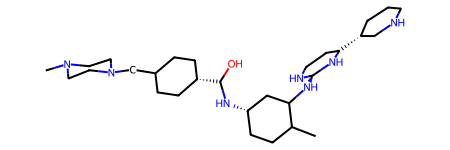

In [167]:
mole

In [168]:
! babel -ipdb STI.pdb -osdf -O sti.sdf

1 molecule converted
30 audit log messages 


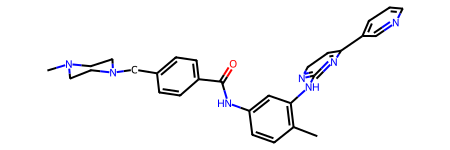

In [170]:
mol_test = Chem.SDMolSupplier('./sti.sdf', sanitize=False)[0]
mol_test

In [52]:
def get_ideal_lig_rcsb(ligand):
    res = requests.get(f"https://files.rcsb.org/ligands/download/{ligand}_ideal.sdf")
    with open(f"{ligand}_ideal.sdf", 'w') as f:
        f.write(res.text)

In [53]:
get_ideal_lig_rcsb('STI')

In [63]:
mole_i = Chem.SDMolSupplier('./STI_ideal.sdf')

In [64]:
mole_i_ = mole_i[0]

[16:49:02] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


[16:49:04] WARNING: More than one matching pattern found - picking one



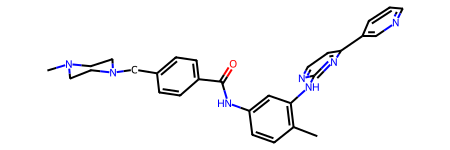

In [65]:
AllChem.AssignBondOrdersFromTemplate(mole_i_, mole)

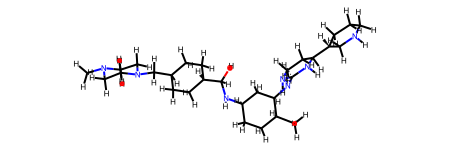

In [66]:
AllChem.AddHs(mole, addCoords=True)